In [326]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import copy
import sys  
import time

from tqdm import tqdm

sys.path.insert(0, '../../')

from soundings.experiments import results as results_calc
from soundings.plotting import results as results_plot
from soundings.deep_learning import mlutilities as ml

In [327]:
f = '/mnt/data1/stock/mlsoundings/preprocessed_alley.npz'
container = np.load(f)
raob = container['raob']
rap  = container['rap']
goes = container['goes']
rtma = container['rtma']
sonde_files = container['sonde_files'] # is this needed now?
container.close()

train_i, val_i, test_i = ml.standard_partition_indicies(sonde_files, percentages=(0.75,0.10,0.15),
                                                        shuffle=True, seed=1234)

RAPtrain,  RAPval,  RAPtest  = rap[train_i], rap[val_i], rap[test_i]
RTMAtrain, RTMAval, RTMAtest = rtma[train_i], rtma[val_i], rtma[test_i]
GOEStrain, GOESval, GOEStest = goes[train_i], goes[val_i], goes[test_i]
RAOBtrain, RAOBval, RAOBtest = raob[train_i], raob[val_i], raob[test_i]
FILEtrain, FILEval, FILEtest = sonde_files[train_i], sonde_files[val_i], sonde_files[test_i]

In [328]:
def _standardizeX(X):
    result = (X - Xmeans) / XstdsFixed
    result[:, Xconstant] = 0.0
    return result

def _unstandardizeX(Xs):
    return Xstds * Xs + Xmeans

def _standardizeT(T):
    result = (T - Tmeans) / TstdsFixed
    result[:, Tconstant] = 0.0
    return result

def _unstandardizeT(Ts):
    return Tstds * Ts + Tmeans


def _normalizeX(X):
    return 2 * ((X - Xmin)/(Xmax - Xmin)) - 1

def _unnormalizeX(Xs):
    return ((Xmax - Xmin) * (Xs + 1) / 2) + Xmin

def _normalizeT(T):
    return 2 * ((T - Tmin)/(Tmax - Tmin)) - 1

def _unnormalizeT(Ts):
    return ((Tmax - Tmin) * (Ts + 1) / 2) + Tmin

In [331]:
rap_output_dims = [1]
Xtrain = RAPtrain[:,:,rap_output_dims]
Ttrain = RAOBtrain[:,:,rap_output_dims]
Xtest  = RAPtest[:,:,rap_output_dims]
Ttest  = RAOBtest[:,:,rap_output_dims]

Xmin = Xtrain.min(axis=0)
Xmax = Xtrain.max(axis=0)

Tmin = Ttrain.min(axis=0)
Tmax = Ttrain.max(axis=0)

Xmeans = Xtrain.mean(axis=0)
Xstds = Xtrain.std(axis=0)
Xconstant = Xstds == 0
XstdsFixed = copy.copy(Xstds)
XstdsFixed[Xconstant] = 1

Tmeans = Ttrain.mean(axis=0)
Tstds = Ttrain.std(axis=0)
Tconstant = Tstds == 0
TstdsFixed = copy.copy(Tstds)
TstdsFixed[Tconstant] = 1

Xtrain = _normalizeX(Xtrain)
Ttrain = _normalizeT(Ttrain)
Xtest = _normalizeX(Xtest)
Ttest = _normalizeT(Ttest)

# Xtrain = _standardizeX(Xtrain)
# Ttrain = _standardizeT(Ttrain)
# Xtest = _standardizeX(Xtest)
# Ttest = _standardizeT(Ttest)

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape)

BATCH_SIZE = 128

Xtrain = tf.data.Dataset.from_tensor_slices(Xtrain).batch(BATCH_SIZE)
Ttrain = tf.data.Dataset.from_tensor_slices(Ttrain).batch(BATCH_SIZE)
Xtest = tf.data.Dataset.from_tensor_slices(Xtest).batch(BATCH_SIZE)
Ttest = tf.data.Dataset.from_tensor_slices(Ttest).batch(BATCH_SIZE)

(19007, 256, 1) (19007, 256, 1) (3798, 256, 1) (3798, 256, 1)


## Generator

In [275]:
list(Xtrain)[0].shape[1:], list(Ttrain)[0].shape[1:]

(TensorShape([256, 1]), TensorShape([256, 1]))

In [372]:
def make_generator_model():
    n_inputs = list(Xtrain)[0].shape[1:]
    n_units_in_conv_layers = [16, 32, 64] 
    kernels_size_and_stride = [(3, 1)]*len(n_units_in_conv_layers)
    n_outputs = list(Ttrain)[0].shape[1:]
    tf.keras.backend.clear_session()
    # encoder
    X = Z = tf.keras.Input(shape=n_inputs)

    for (kernel, stride), units in zip(kernels_size_and_stride, n_units_in_conv_layers):
        Z = tf.keras.layers.Conv1D(units, kernel_size=kernel,
                                   strides=stride, padding='same')(Z)
        Z = tf.keras.layers.LeakyReLU(alpha=0.2)(Z)
        Z = tf.keras.layers.MaxPooling1D(pool_size=2)(Z)

    skips = list(reversed([layer for layer in tf.keras.Model(X, Z).layers if 'max' in layer.name]))

    # bottleneck layer
    Z = tf.keras.layers.Conv1D(
            n_units_in_conv_layers[-1], 
            kernel_size=kernels_size_and_stride[-1][0], 
            strides=kernels_size_and_stride[-1][1], 
            padding='same', name='bottleneck')(Z)
    Z = tf.keras.layers.LeakyReLU(alpha=0.2)(Z)
    Z = tf.keras.layers.Dropout(0.50)(Z)

    # decoder
    for (kernel, stride), units, skip in zip(reversed(kernels_size_and_stride),
                                             reversed(n_units_in_conv_layers),
                                             skips):
        Z = tf.keras.layers.Conv1D(units, kernel_size=kernel, 
                                   strides=stride, padding='same')(Z)
        Z = tf.keras.layers.BatchNormalization()(Z)
        Z = tf.keras.layers.Activation('relu')(Z)
        Z = tf.keras.layers.Concatenate(axis=2)([Z, skip.output])
        Z = tf.keras.layers.UpSampling1D(size=2)(Z)
        Z = tf.keras.layers.Dropout(0.35)(Z)

    # final conv layer (linear; no activation)
    Z = tf.keras.layers.Conv1D(
            n_outputs[-1], kernel_size=kernels_size_and_stride[0][0], 
            strides=kernels_size_and_stride[0][1], padding='same')(Z)
    print(X.shape, Z.shape)
    # add only the temperature profile back to Z.
    Y = tf.keras.layers.Add()([X, Z])
    return tf.keras.Model(inputs=X, outputs=Y)


(None, 256, 1) (None, 256, 1)


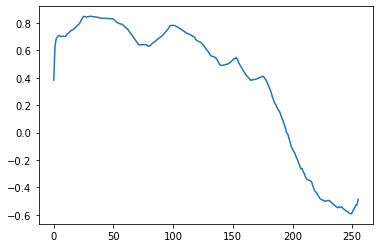

In [373]:
generator = make_generator_model()
batch = tf.convert_to_tensor(list(Xtrain.take(1).as_numpy_iterator())[0])[:8]
generated_image = generator(batch, training=False)

plt.plot(generated_image[0,:, 0])

In [374]:
generator.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 256, 16)      64          input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 256, 16)      0           conv1d[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 128, 16)      0           leaky_re_lu[0][0]                
_______________________________________________________________________________________

## Discriminator

In [392]:
def make_discriminator_model():
    tf.keras.backend.clear_session()
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(256, 1)))
    model.add(tf.keras.layers.Conv1D(4, 3, strides=1, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv1D(8, 3, strides=1, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Conv1D(16, 3, strides=1, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.Conv1D(32, 3, strides=1, padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.MaxPooling1D(2))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [393]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor(
[[6.740947 ]
 [7.1682925]
 [6.0736914]
 [7.3659744]
 [6.2660904]
 [3.6720517]
 [6.6244125]
 [6.897139 ]], shape=(8, 1), dtype=float32)


In [394]:
discriminator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 256, 4)            16        
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 4)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 128, 4)            0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 4)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 128, 8)            104       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 8)            0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 64, 8)             0

## Loss

In [395]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [396]:
def discriminator_loss(real_output, fake_output):
    real_loss  = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss  = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [397]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [398]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [399]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(X, T):
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(X, training=True)

        real_output = discriminator(T, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [400]:
G_loss, D_loss = [], []
def train(Xtrain, Ttrain, epochs):
    for epoch in tqdm(range(epochs)):
        for X, T in zip(Xtrain, Ttrain):
            gen_loss, disc_loss = train_step(X, T)
            G_loss.append(gen_loss.numpy())
            D_loss.append(disc_loss.numpy())

In [408]:
EPOCHS = 500
discriminator = make_discriminator_model()
discriminator = make_discriminator_model()

train(Xtrain, Ttrain, EPOCHS)

100%|██████████| 500/500 [14:27<00:00,  1.74s/it]


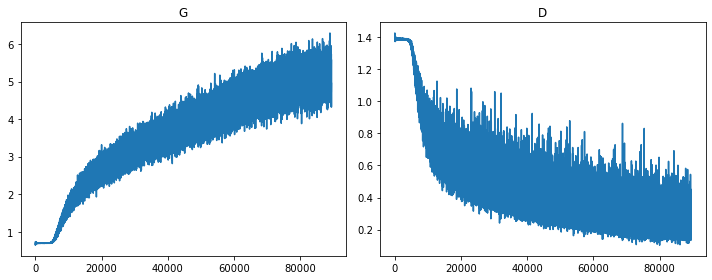

In [409]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(G_loss)
axs[1].plot(D_loss)

axs[0].set_title('G'), axs[1].set_title('D');
fig.tight_layout()

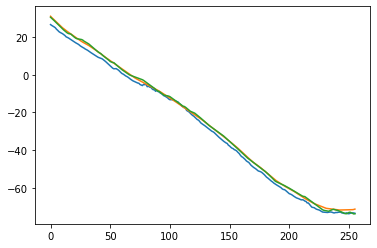

In [410]:
batch = tf.convert_to_tensor(list(Xtrain.take(1).as_numpy_iterator())[0])[:8]
generated_image = _unnormalizeT(generator(batch, training=False))
i = 7
plt.plot(generated_image[i])
plt.plot(RAPtrain[i,:,1])
plt.plot(RAOBtrain[i,:,1])

In [411]:
baseline = dict()

sets = ['train', 'val', 'test']

for i, (RAP, RAOB) in enumerate([(RAPtrain, RAOBtrain),
                                 (RAPval  , RAOBval),
                                 (RAPtest , RAOBtest)]):
    (rmse, mean_rmse, # temperature
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,1], RAOB[:, :, 1])
    baseline[f'rap_temperature_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_temperature_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_temperature_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc
    
    (rmse, mean_rmse, #dewpoint
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(RAP[:,:,2], RAOB[:, :, 2])
    baseline[f'rap_dewpoint_{sets[i]}_rmse'] = rmse.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse'] = mean_rmse
    baseline[f'rap_dewpoint_{sets[i]}_rmse_sfc'] = rmse_sfc.tolist()
    baseline[f'rap_dewpoint_{sets[i]}_mean_rmse_sfc'] = mean_rmse_sfc

In [412]:
r = dict()
sets = ['train', 'test']
for j, (X, RAP, T) in enumerate([(Xtrain, RAPtrain, RAOBtrain),
                                 (Xtest , RAPtest , RAOBtest)]):
    Y = []
    for batch in X:
        Y.append(_unnormalizeT(generator(batch, training=False)).numpy())
    Y = np.vstack(Y)
    (rmse, mean_rmse,
     rmse_sfc, mean_rmse_sfc) = results_calc.compute_profile_rmses(Y, T[:,:,rap_output_dims])
    r[f'ml_temperature_{sets[j]}_rmse'] = rmse.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse'] = mean_rmse
    r[f'ml_temperature_{sets[j]}_rmse_sfc'] = rmse_sfc.tolist()
    r[f'ml_temperature_{sets[j]}_mean_rmse_sfc'] = mean_rmse_sfc

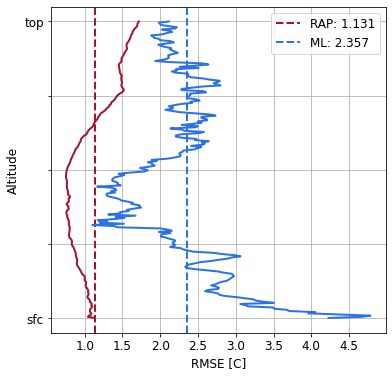

In [413]:
v = 'temperature'
ml_rmse = np.asarray(r[f'ml_{v}_test_rmse'])
ml_mean_rmse = r[f'ml_{v}_test_mean_rmse']
rap_rmse = baseline[f'rap_{v}_test_rmse']
rap_mean_rmse = baseline[f'rap_{v}_test_mean_rmse']
results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)

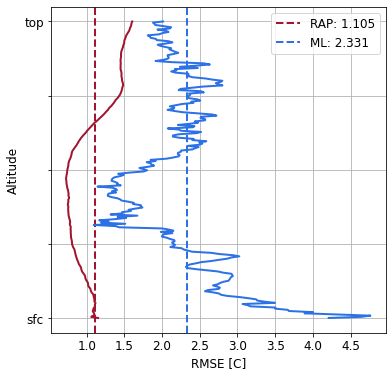

In [414]:
v = 'temperature'
ml_rmse = np.asarray(r[f'ml_{v}_train_rmse'])
ml_mean_rmse = r[f'ml_{v}_train_mean_rmse']
rap_rmse = baseline[f'rap_{v}_train_rmse']
rap_mean_rmse = baseline[f'rap_{v}_train_mean_rmse']
results_plot.plot_altitude_rmse_verticle_2(ml_rmse, ml_mean_rmse, rap_rmse, rap_mean_rmse)